In [394]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
#from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

### Part 1: Extract license plate from sample image

In [395]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [396]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


1/1 [==============================] - 1s 965ms/step


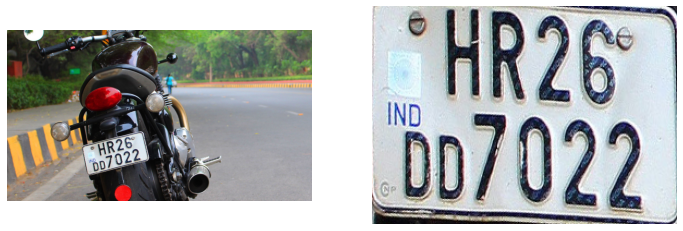

In [683]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , img, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, img, cor

test_image_path = "india_motor_plate.jpg"
vehicle, img,cor = get_plate(os.path.join("/Users/apple/Desktop/Project/Team 6/Plate_examples" ,test_image_path))


fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(img[0])

## Part 2: Segementing license characters

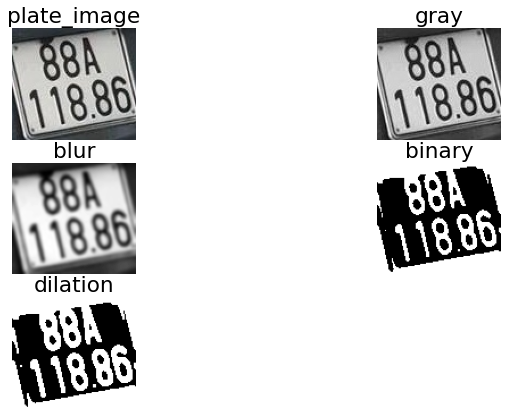

In [703]:

if (len(img)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    #plate_image = cv2.convertScaleAbs(img, alpha=(255.0))
    #plt.imshow(plate_image)

    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

plt.savefig("threshding.png", dpi=300)

0 56 109 43
0 27 4 17
0 0 109 47
4 45 1 4
7 60 1 1
16 55 13 33
34 52 12 32
48 49 18 33
70 46 18 32
71 77 2 2
87 42 18 33
107 58 2 5
Detect 5 letters...


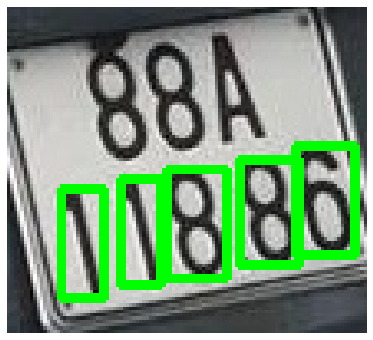

In [704]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 180, 180

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    print(x,y,w,h)
    ratio = h/w
    if 1<=ratio<=5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.3: # Select contour which has the height larger than 50% of the plate_image
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and give prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)
            
print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
plt.savefig('grab_digit_contour.png',dpi=300)

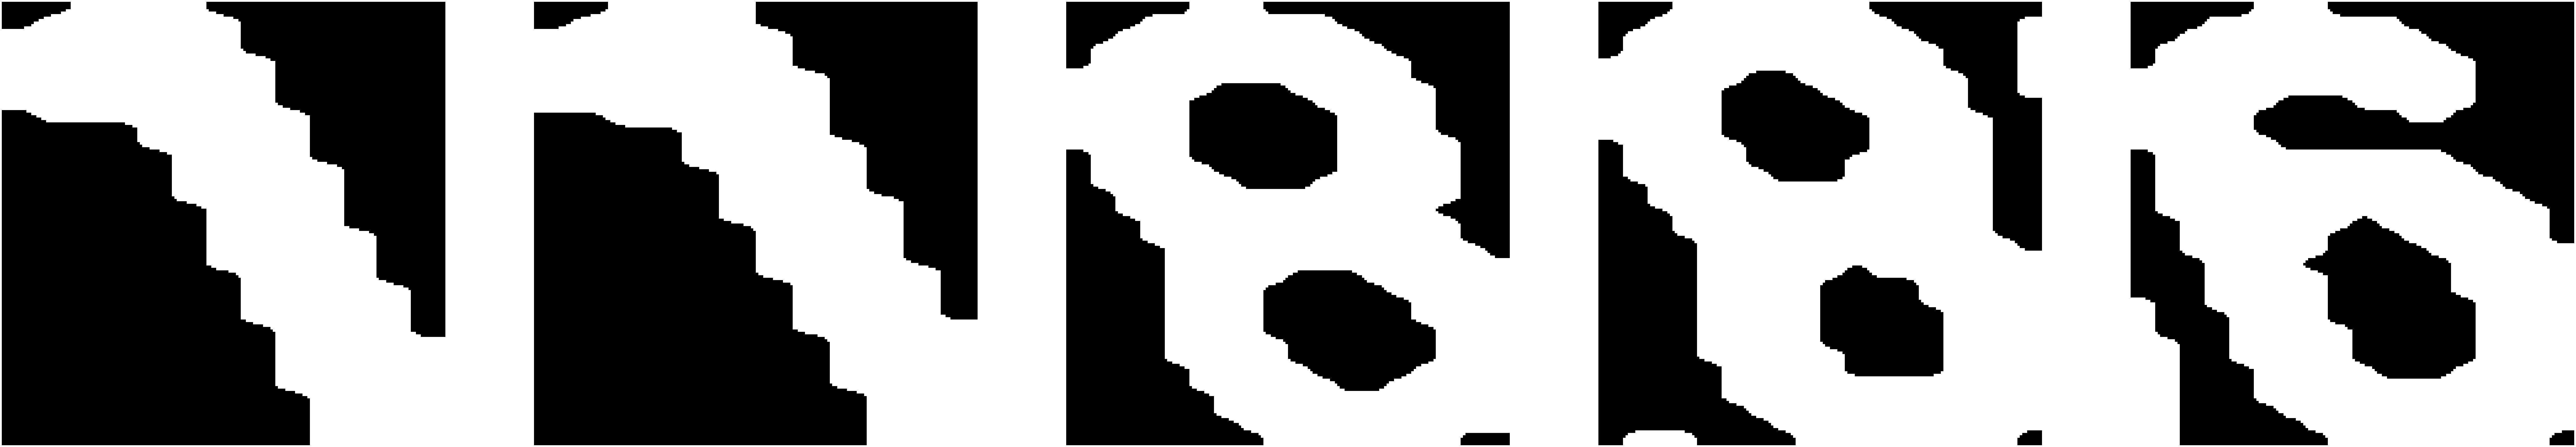

In [705]:
fig = plt.figure(figsize=(180,180))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
    path="/Users/apple/Desktop/Project/Team 6/new_images"
    cv2.imwrite(os.path.join(path ,str(i))+test_image_path,crop_characters[i])
#plt.savefig("segmented_leter.png",dpi=300)    


In [512]:
for i in range(len(crop_characters)):
    cv2.imwrite(crop_characters[i],"/Users/apple/Desktop/Project/Team 6/new_images")


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - Can't convert object to 'str' for 'filename'
>  - Can't convert object to 'str' for 'filename'


In [706]:
# loading model 2.0
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('Model 3.0.h5')

In [707]:
# evaluation of the model
out = []
#im = ((crop_characters[0]))
#print(im.shape)
#p1 = model.predict(im)
for i in range(len(crop_characters)):
     print(i)
     x = crop_characters[i]
     x = np.reshape(x, (180, 180, 1))
     x = np.concatenate([x, x, x], axis=2)
     x = np.expand_dims(x, axis=0)
     x = np.concatenate([x for _ in range(32)], axis=0)
     # print(x.shape)
     p1 = model.predict(x)
     c=np.argmax(p1)
     print (c)
     # print(p1)
     out.append(c)

# print(out)


0
1/1 [==============================] - 0s 384ms/step
1
1
1/1 [==============================] - 0s 57ms/step
1
2
1/1 [==============================] - 0s 94ms/step
1088
3
1/1 [==============================] - 0s 82ms/step
9
4
1/1 [==============================] - 0s 79ms/step
1086


In [708]:
for i in range(len(out)):
    print(out[i])

1
1
1088
9
1086


In [709]:
classes = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
len(classes)

36

In [710]:
txt = ""
for i in (out):
    print (i)
    if(i<36):
        txt = txt+classes[i]
    else:
        txt = txt+"-"
print (txt)

1
1
1088
9
1086
11-9-


In [711]:
p1[:5]

array([[1.5902877e-02, 7.1547686e-07, 4.8981796e-10, 6.9609884e-04,
        5.1536353e-04, 2.0125572e-01, 7.2274292e-01, 1.1637225e-12,
        1.7451057e-03, 3.0933373e-04, 1.0561637e-04, 1.4109047e-03,
        2.3117913e-03, 2.6281067e-04, 1.1753711e-03, 9.5956375e-07,
        4.6365689e-03, 2.1166973e-02, 2.6749406e-04, 2.0774556e-05,
        6.3881904e-09, 1.9492816e-04, 7.7275772e-06, 8.3840232e-06,
        7.7422168e-03, 2.0890381e-07, 1.5675403e-05, 2.0249652e-06,
        2.9977693e-04, 3.2740270e-05, 1.7143769e-02, 2.0696130e-05,
        4.9316634e-07, 3.9345223e-06, 1.1946684e-09, 4.8953268e-08],
       [1.5902877e-02, 7.1547686e-07, 4.8981796e-10, 6.9609884e-04,
        5.1536353e-04, 2.0125572e-01, 7.2274292e-01, 1.1637225e-12,
        1.7451057e-03, 3.0933373e-04, 1.0561637e-04, 1.4109047e-03,
        2.3117913e-03, 2.6281067e-04, 1.1753711e-03, 9.5956375e-07,
        4.6365689e-03, 2.1166973e-02, 2.6749406e-04, 2.0774556e-05,
        6.3881904e-09, 1.9492816e-04, 7.7275772

In [712]:
import numpy as np
p1_reduced = [np.argmax(pr) for pr in p1]

c = np.argmax(out[0][])
c

SyntaxError: invalid syntax (1484324454.py, line 4)

In [ ]:
temp = np.reshape(im, (180, 180, 1))

In [ ]:
temp = np.concatenate([temp, temp, temp], axis=2)

In [ ]:
temp = np.expand_dims(temp, axis=0)

In [ ]:
temp = np.concatenate([temp for _ in range(32)], axis=0)

In [ ]:
temp.shape

(32, 180, 180, 3)

In [ ]:
im = temp

In [ ]:
im.shape

(32, 180, 180, 3)

In [ ]:
im = tf.convert_to_tensor(im)
im.shape

TensorShape([32, 180, 180, 3])